In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision, Time Series, and Survival Analysis (Lectures 18 to 20)

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

Let's sort the data by dates:

In [9]:
display (df.sort_values(by=["Date"]))
display(df.sort_values(by=['region', "Date"]))
display(df.sort_values(by=['type','region', "Date"]))

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,2015,Southeast
51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.00,organic,2015,Chicago
51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.00,organic,2015,HarrisburgScranton
51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.00,conventional,2015,Pittsburgh
51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.00,organic,2015,Boise
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2018-03-25,1.36,908202.13,142681.06,463136.28,174975.75,127409.04,103579.41,22467.04,1362.59,conventional,2018,Chicago
0,2018-03-25,0.70,9010588.32,3999735.71,966589.50,30130.82,4014132.29,3398569.92,546409.74,69152.63,conventional,2018,SouthCentral
0,2018-03-25,1.42,163496.70,29253.30,5080.04,0.00,129163.36,109052.26,20111.10,0.00,organic,2018,SouthCentral
0,2018-03-25,1.70,190257.38,29644.09,70982.10,0.00,89631.19,89424.11,207.08,0.00,organic,2018,California


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany
51,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.00,organic,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.00,conventional,2015,Albany
50,2015-01-11,1.77,1182.56,39.00,305.12,0.00,838.44,838.44,0.00,0.00,organic,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.00,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.00,organic,2018,WestTexNewMexico
1,2018-03-18,0.88,855251.17,457635.79,137597.04,8422.08,251596.26,151191.85,98535.60,1868.81,conventional,2018,WestTexNewMexico
1,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.00,organic,2018,WestTexNewMexico
0,2018-03-25,0.84,965185.06,438526.12,199585.90,11017.42,316055.62,153009.89,160999.10,2046.63,conventional,2018,WestTexNewMexico


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
48,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
47,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
3,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
2,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
1,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We have different measurements for each region and type.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

Let's try to plot the spacing between dates for each region.

In [10]:
# From Lecture 19
def plot_time_spacing_distribution(df, region="Adelaide"):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[df['region'] == region]#modify this line
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for Albany:
Date
0 days    169
7 days    168
Name: count, dtype: int64



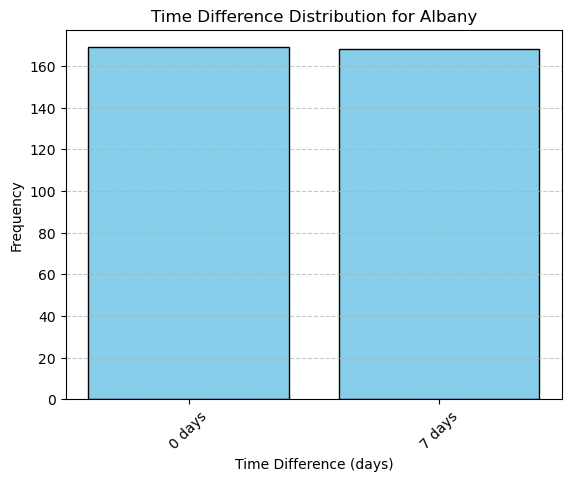

In [11]:
plot_time_spacing_distribution(df, region='Albany')

Time spacing counts for WestTexNewMexico:
Date
0 days    166
7 days    168
Name: count, dtype: int64



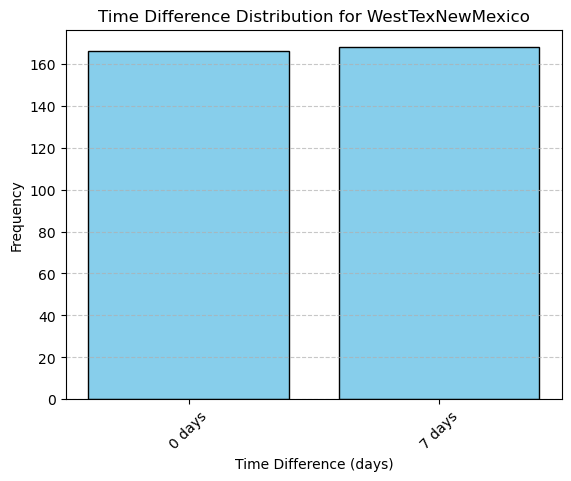

In [12]:
plot_time_spacing_distribution(df, region='WestTexNewMexico')

Here, we see that the dates spacing are either 0 or 7 days. The zero day spacing is for the same region with different types. While the 7 day spacing is for different regions.
  We can say that, between region and types, there is **7** day difference 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

It seems below that there are overlaps between regions, for example, `TotalUS`, `West`, `Northeast` are not names of us cities, they most likely refer to regions in the us as a whole, which may include some of the cities.

In [13]:
print(df['region'].unique())

['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']


<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2024W2/tree/main/lectures), with some improvements.

In [14]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [15]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [16]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [17]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

We will extract `AveragePrice` from our train and test set and use it as our predictions

In [18]:
from sklearn.metrics import r2_score
X_train, y_train = df_train.drop(columns=['AveragePriceNextWeek']), df_train['AveragePriceNextWeek']
X_test, y_test = df_test.drop(columns=['AveragePriceNextWeek']), df_test['AveragePriceNextWeek']

display(X_train)
# display(y_train)

display(X_test)
# display(y_test)

pred_train = X_train['AveragePrice']
pred_test = X_test['AveragePrice']

train_r2 = r2_score(y_train, pred_train)
print(train_r2)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2017-08-27,2.50,16137.93,2616.96,3672.96,0.00,9848.01,9816.58,31.43,0.0,organic,2017,WestTexNewMexico
18219,2017-09-03,2.39,7657.47,927.27,4056.73,0.00,2673.47,2629.18,44.29,0.0,organic,2017,WestTexNewMexico
18220,2017-09-10,2.38,11857.31,1562.10,4565.41,0.00,5729.80,5719.96,9.84,0.0,organic,2017,WestTexNewMexico
18221,2017-09-17,2.36,10464.29,1845.14,2819.17,0.00,5799.98,5796.65,3.33,0.0,organic,2017,WestTexNewMexico


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
143,2017-10-01,1.69,71205.11,4411.02,57416.25,77.85,9299.99,5069.66,4230.33,0.0,conventional,2017,Albany
144,2017-10-08,1.78,55368.61,3679.82,45843.75,42.63,5802.41,2148.20,3654.21,0.0,conventional,2017,Albany
145,2017-10-15,1.65,73574.89,3383.35,63355.37,62.45,6773.72,3882.02,2891.70,0.0,conventional,2017,Albany
146,2017-10-22,1.56,69704.09,3758.80,57340.30,35.48,8569.51,5101.64,3467.87,0.0,conventional,2017,Albany
147,2017-10-29,1.67,69432.23,2959.76,57585.49,57.94,8829.04,5050.91,3778.13,0.0,conventional,2017,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico


0.8285800937261841


In [19]:
test_r2 = r2_score(y_test, pred_test)
print(test_r2)

0.7631780188583048


In [20]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

First we will construct a preprocessor for our dataset

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15441 entries, 0 to 18222
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  15441 non-null  datetime64[ns]
 1   AveragePrice          15441 non-null  float64       
 2   Total Volume          15441 non-null  float64       
 3   4046                  15441 non-null  float64       
 4   4225                  15441 non-null  float64       
 5   4770                  15441 non-null  float64       
 6   Total Bags            15441 non-null  float64       
 7   Small Bags            15441 non-null  float64       
 8   Large Bags            15441 non-null  float64       
 9   XLarge Bags           15441 non-null  float64       
 10  type                  15441 non-null  object        
 11  year                  15441 non-null  int64         
 12  region                15441 non-null  object        
 13  AveragePriceNextWeek 

In [22]:
numeric_features = ['AveragePrice','Total Volume','4046','4225', '4770', 'Total Bags','Small Bags','Large Bags','XLarge Bags']
categorical_features = ['type','year','region']
drop_features = ['Date']
target = ['AveragePriceNextWeek']

In [23]:
#From lecture 19 modified
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(train_df.columns) != all_features:
        print("Missing columns", set(train_df.columns) - all_features)
        print("Extra columns", all_features - set(train_df.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(train_df)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )

    y_train = train_df['AveragePriceNextWeek']
    y_test = test_df["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features,
    drop_features, target
)

display(X_train_enc)
display(y_train)
print(X_train_enc.columns)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type_conventional,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,-0.432512,-0.234535,-0.229503,-0.222203,-0.214954,-0.232206,-0.229907,-0.223154,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.383676,-0.234440,-0.230948,-0.219448,-0.214272,-0.233587,-0.231513,-0.223789,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.554604,-0.233469,-0.231018,-0.219530,-0.214196,-0.229850,-0.226469,-0.224325,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.823205,-0.233283,-0.230996,-0.218170,-0.213945,-0.230999,-0.228629,-0.222193,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.994133,-0.225747,-0.230668,-0.196131,-0.213811,-0.232627,-0.229930,-0.224856,-0.172063,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2.693027,-0.241780,-0.229664,-0.242429,-0.215395,-0.232066,-0.229029,-0.225402,-0.172063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18219,2.424426,-0.244264,-0.231008,-0.242114,-0.215395,-0.239735,-0.239057,-0.225344,-0.172063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18220,2.400008,-0.243034,-0.230503,-0.241696,-0.215395,-0.236468,-0.234745,-0.225499,-0.172063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18221,2.351171,-0.243442,-0.230278,-0.243130,-0.215395,-0.236393,-0.234638,-0.225529,-0.172063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


0        1.24
1        1.17
2        1.06
3        0.99
4        0.99
         ... 
18218    2.39
18219    2.38
18220    2.36
18221    2.26
18222    2.37
Name: AveragePriceNextWeek, Length: 15441, dtype: float64

Index(['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'type_conventional',
       'type_organic', 'year_2015', 'year_2016', 'year_2017', 'region_Albany',
       'region_Atlanta', 'region_BaltimoreWashington', 'region_Boise',
       'region_Boston', 'region_BuffaloRochester', 'region_California',
       'region_Charlotte', 'region_Chicago', 'region_CincinnatiDayton',
       'region_Columbus', 'region_DallasFtWorth', 'region_Denver',
       'region_Detroit', 'region_GrandRapids', 'region_GreatLakes',
       'region_HarrisburgScranton', 'region_HartfordSpringfield',
       'region_Houston', 'region_Indianapolis', 'region_Jacksonville',
       'region_LasVegas', 'region_LosAngeles', 'region_Louisville',
       'region_MiamiFtLauderdale', 'region_Midsouth', 'region_Nashville',
       'region_NewOrleansMobile', 'region_NewYork', 'region_Northeast',
       'region_NorthernNewEngland', 'region_Orlando', 'region_Philadelph

Then we will use `Ridge` to score on our data

In [25]:
from sklearn.linear_model import Ridge
#From lecture 19 ,modified
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
    lr_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(test_df, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["ridge"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [26]:
score_lr_print_coeff(preprocessor, df_train, y_train, df_test, y_test, X_train_enc)

Train score: 0.85
Test score: 0.80


,Coef
AveragePrice,0.325180
region_SanFrancisco,0.091341
region_HartfordSpringfield,0.088819
region_NewYork,0.070054
type_organic,0.051681
...,...
region_Denver,-0.047878
type_conventional,-0.051681
region_SouthCentral,-0.067115
region_DallasFtWorth,-0.068354


First, we will try to encode the `Date` as months

In [27]:
df_train = df_train.assign(
    Month=df_train["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
df_test = df_test.assign(Month=df_test["Date"].apply(lambda x: x.month_name()))

df_train[["Date", "Month"]].sort_values(by="Month")

,Date,Month
1304,2017-04-30,April
9869,2016-04-17,April
9025,2016-04-24,April
3332,2017-04-30,April
3331,2017-04-23,April
...,...,...
11241,2016-09-04,September
11242,2016-09-11,September
11243,2016-09-18,September
11293,2017-09-03,September


In [28]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train, df_test, 
    numeric_features, 
    categorical_features + ["Month"], 
    drop_features,
    target
)

display(X_train_enc)
print(X_train_enc.columns)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type_conventional,...,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,-0.432512,-0.234535,-0.229503,-0.222203,-0.214954,-0.232206,-0.229907,-0.223154,-0.172063,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.383676,-0.234440,-0.230948,-0.219448,-0.214272,-0.233587,-0.231513,-0.223789,-0.172063,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.554604,-0.233469,-0.231018,-0.219530,-0.214196,-0.229850,-0.226469,-0.224325,-0.172063,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.823205,-0.233283,-0.230996,-0.218170,-0.213945,-0.230999,-0.228629,-0.222193,-0.172063,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.994133,-0.225747,-0.230668,-0.196131,-0.213811,-0.232627,-0.229930,-0.224856,-0.172063,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2.693027,-0.241780,-0.229664,-0.242429,-0.215395,-0.232066,-0.229029,-0.225402,-0.172063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18219,2.424426,-0.244264,-0.231008,-0.242114,-0.215395,-0.239735,-0.239057,-0.225344,-0.172063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18220,2.400008,-0.243034,-0.230503,-0.241696,-0.215395,-0.236468,-0.234745,-0.225499,-0.172063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18221,2.351171,-0.243442,-0.230278,-0.243130,-0.215395,-0.236393,-0.234638,-0.225529,-0.172063,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Index(['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'type_conventional',
       'type_organic', 'year_2015', 'year_2016', 'year_2017', 'region_Albany',
       'region_Atlanta', 'region_BaltimoreWashington', 'region_Boise',
       'region_Boston', 'region_BuffaloRochester', 'region_California',
       'region_Charlotte', 'region_Chicago', 'region_CincinnatiDayton',
       'region_Columbus', 'region_DallasFtWorth', 'region_Denver',
       'region_Detroit', 'region_GrandRapids', 'region_GreatLakes',
       'region_HarrisburgScranton', 'region_HartfordSpringfield',
       'region_Houston', 'region_Indianapolis', 'region_Jacksonville',
       'region_LasVegas', 'region_LosAngeles', 'region_Louisville',
       'region_MiamiFtLauderdale', 'region_Midsouth', 'region_Nashville',
       'region_NewOrleansMobile', 'region_NewYork', 'region_Northeast',
       'region_NorthernNewEngland', 'region_Orlando', 'region_Philadelph

In [29]:
score_lr_print_coeff(preprocessor, df_train, y_train, df_test, y_test, X_train_enc)

Train score: 0.85
Test score: 0.80


,Coef
AveragePrice,0.311424
region_SanFrancisco,0.106214
region_HartfordSpringfield,0.103903
region_NewYork,0.081879
region_Philadelphia,0.060428
...,...
region_Denver,-0.055380
type_conventional,-0.060229
region_SouthCentral,-0.077472
region_DallasFtWorth,-0.079459


There doesn't seem to be any improvements in the scores, the coefficients did change a little.

Now let's try encoding the `Date` as seasons.

In [30]:
#From Lecture 19 
def get_season(month):
    # remember this is Australia
    WINTER_MONTHS = ["June", "July", "August"] 
    AUTUMN_MONTHS = ["March", "April", "May"]
    SUMMER_MONTHS = ["December", "January", "February"]
    SPRING_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

In [31]:
df_train = df_train.assign(Season=df_train["Month"].apply(get_season))
df_test = df_test.assign(Season=df_test["Month"].apply(get_season))

df_train

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Month,Season
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24,January,Summer
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17,January,Summer
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06,January,Summer
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99,January,Summer
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99,February,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2017-08-27,2.50,16137.93,2616.96,3672.96,0.00,9848.01,9816.58,31.43,0.0,organic,2017,WestTexNewMexico,2.39,August,Winter
18219,2017-09-03,2.39,7657.47,927.27,4056.73,0.00,2673.47,2629.18,44.29,0.0,organic,2017,WestTexNewMexico,2.38,September,Fall
18220,2017-09-10,2.38,11857.31,1562.10,4565.41,0.00,5729.80,5719.96,9.84,0.0,organic,2017,WestTexNewMexico,2.36,September,Fall
18221,2017-09-17,2.36,10464.29,1845.14,2819.17,0.00,5799.98,5796.65,3.33,0.0,organic,2017,WestTexNewMexico,2.26,September,Fall


In [32]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features + ["Season"],
    drop_features + ["Month"],
    target
)

X_train_enc.columns

Index(['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'type_conventional',
       'type_organic', 'year_2015', 'year_2016', 'year_2017', 'region_Albany',
       'region_Atlanta', 'region_BaltimoreWashington', 'region_Boise',
       'region_Boston', 'region_BuffaloRochester', 'region_California',
       'region_Charlotte', 'region_Chicago', 'region_CincinnatiDayton',
       'region_Columbus', 'region_DallasFtWorth', 'region_Denver',
       'region_Detroit', 'region_GrandRapids', 'region_GreatLakes',
       'region_HarrisburgScranton', 'region_HartfordSpringfield',
       'region_Houston', 'region_Indianapolis', 'region_Jacksonville',
       'region_LasVegas', 'region_LosAngeles', 'region_Louisville',
       'region_MiamiFtLauderdale', 'region_Midsouth', 'region_Nashville',
       'region_NewOrleansMobile', 'region_NewYork', 'region_Northeast',
       'region_NorthernNewEngland', 'region_Orlando', 'region_Philadelph

In [33]:
coeff_df = score_lr_print_coeff(
    preprocessor, df_train, y_train, df_test, y_test, X_train_enc
)

coeff_df.loc[["Season_Fall", "Season_Summer", "Season_Winter", "Season_Autumn"]]

Train score: 0.85
Test score: 0.79


,Coef
Season_Fall,0.023480
Season_Summer,-0.033566
Season_Winter,0.019675
Season_Autumn,-0.009589


Again, the scores stays relatively the same, but here we see that Fall and Winter season seems to be when the average sales are higher. 

Out of the two approaches we tried, none seems to have changed the scores by much, but we did get some insights about the coefficients. For example, In the seasons method, we see what seasons have higher average sales  

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. If we are collecting data about sales or transactions a store is making, where each row is a transaction. We may not have equal timed spaces. as a customer may make a purchase at any time.
2. lag based feature, because one column of a lagged feature is supposed to represent data collected an equal amount of time interval in the past or future. If we have unequal time spaces we would have to do a bit of preprocessing, otherwise the data would be skewed and inconsistent 
3. It's because Ridge is a linear model, and cannot capture the periodic pattern of the time of day. We tackled this problem by using OHE to encode the day and hour and adding interaction features. Ridge can now learn coefficients for features such as "Sat 09:00" to capture when busy hours are. This leads to a better model

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. For each of the 4 classes, lr will learn 10 coefficients for the 10 features and 1 intercept. So in total, we will have 44 parameters.
2. Neural networks work great for structured data, such as timeseries, 2D image, 3D image or video. and transfer learning is commonly used for such data because pretrained models are for intensive resources required.
3. I will use pre-trained models as feature extraction to get feature vectors for all our images. I can then use Logistic Regression to classify our images. I choose this method because it is not possible to train my own model, but at the same time I cannot just use models pretrained on public datasets, because they do not contain my images of UBC Comp Sci Faculty Member, and so I must use feature extractor to get useful information about my images which can then be trained with Logistic Regression to make decent predictions.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2.3 Survival analysis
<hr>

rubric={points:6}

The following questions pertain to Lecture 21 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer? Briefly explain your answer. 
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 6

1. We tend to underestimate the tenure, because we are only recording tenure untill the time of data collection (we collect tenure shorter than in reality) and this impacts the model training which resulted in lower predictions.
2. We don't have enough information to answer. Although it may seem that customer b will leave sooner because of longer stay, it may be that other features/factors impact a customer's churn. In the course notes for example, customers without two year contract tend to have a lower survival probability than those with.
3. It implies the customer will (almost) never churn

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)